In [1]:
import sys
sys.path.append("/home/twhit/smc_object_detection/")

from utils.misc import select_cuda_device
device = select_cuda_device()

Selected device 2, which has 10820 MB available.


In [2]:
import torch
from torch.distributions import Poisson

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pickle

from scipy.stats import truncpareto

from hydra import initialize, compose
from hydra.utils import instantiate

from astropy.io import fits
from astropy.wcs import WCS

from bliss.catalog import FullCatalog, convert_mag_to_nmgy, convert_nmgy_to_mag

In [3]:
with initialize(config_path=".", version_base=None):
    cfg = compose(config_name="config")

---

### **SDSS image**

In [4]:
sdss = instantiate(cfg.surveys.sdss)
sdss.prepare_data()

In [5]:
field52_rband_fits = fits.open('/data/scratch/twhit/m71/6895/3/52/frame-r-006895-3-0052.fits')
field52_rband_wcs = WCS(field52_rband_fits[0].header)

# We will catalog a 320x320 pixel region with lower left corner at (1728, 900)
field52_rband_wcs.pixel_to_world(1728, 900)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (ICRS): (ra, dec) in deg
    (298.40759022, 18.78339333)>

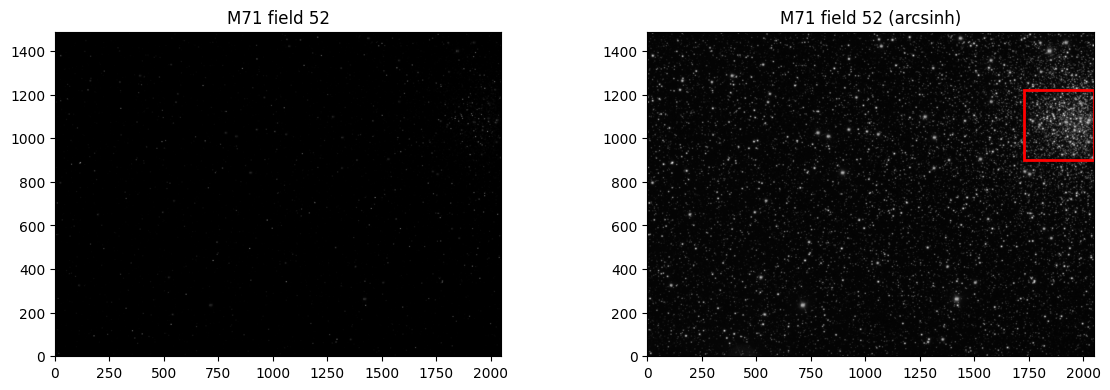

In [6]:
field52_image = field52_rband_fits[0].data
field52_image_arcsinh = np.arcsinh(field52_image)

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
rect = Rectangle((1728, 900), 320, 320, linewidth=2, edgecolor='r', facecolor='none')

_ = ax[0].imshow(field52_image, origin='lower', cmap='gray')
_ = ax[0].set_title('M71 field 52')

_ = ax[1].imshow(field52_image_arcsinh, origin='lower', cmap='gray')
_ = plt.gca().add_patch(rect)
_ = ax[1].set_title('M71 field 52 (arcsinh)')

_ = fig.tight_layout()

---

### **Hubble catalog**

All magnitudes and fluxes are in the r-band.

In [7]:
# wget https://archive.stsci.edu/pub/hlsp/acsggct/ngc6838/hlsp_acsggct_hst_acs-wfc_ngc6838_r.rdviq.cal.adj.zpt

hubble_catalog = np.loadtxt('/data/scratch/twhit/m71/hlsp_acsggct_hst_acs-wfc_ngc6838_r.rdviq.cal.adj.zpt',
                            skiprows = 3, usecols=(9, 21, 22))

In [8]:
fluxes_all = convert_mag_to_nmgy(torch.from_numpy(hubble_catalog[:,0])) * 1.15 # adjust to align Hubble and SDSS filter curves
mags_all = convert_nmgy_to_mag(fluxes_all)

ra_all = torch.from_numpy(hubble_catalog[:,1])
dec_all = torch.from_numpy(hubble_catalog[:,2])

locs_all = FullCatalog.plocs_from_ra_dec(ra_all, dec_all, field52_rband_wcs)

In [9]:
locs_mask = (locs_all[:,0] > 900) & (locs_all[:,0] < 1220)
locs_mask &= (locs_all[:,1] > 1728) & (locs_all[:,1] < 2048)

locs = locs_all[locs_mask]
locs -= locs.min(0).values
mags = mags_all[locs_mask]
fluxes = fluxes_all[locs_mask]

In [10]:
mag_threshold = 24.0

locs_magcut = locs[mags <= mag_threshold]
mags_magcut = mags[mags <= mag_threshold]
fluxes_magcut = fluxes[mags <= mag_threshold]

---

### **Store image tiles and tile catalogs**

In [11]:
tile_dim = 8
max_objects_per_tile = 25

# Subset to the 320x320 pixel region and partition it into 8x8 pixel tiles
image = torch.from_numpy(field52_image[900:1220, 1728:2048].astype(np.float32))
tiles = image.unfold(0, tile_dim, tile_dim).unfold(1, tile_dim, tile_dim)

In [12]:
locs_index = locs // tile_dim
tile_counts = torch.zeros(tiles.shape[0], tiles.shape[1])
tile_locs = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile, 2)
tile_mags = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)
tile_fluxes = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)

locs_index_magcut = locs_magcut // tile_dim
tile_counts_magcut = torch.zeros(tiles.shape[0], tiles.shape[1])
tile_locs_magcut = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile, 2)
tile_mags_magcut = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)
tile_fluxes_magcut = torch.zeros(tiles.shape[0], tiles.shape[1], max_objects_per_tile)

for h in range(tiles.shape[0]):
    for w in range(tiles.shape[1]):
        tile_counts[h,w] = (locs_index == torch.tensor([h,w])).all(-1).sum()
        tile_locs[h,w,:tile_counts[h,w].int()] = (locs % tile_dim)[(locs_index == torch.tensor([h,w])).all(-1)]
        tile_mags[h,w,:tile_counts[h,w].int()] = mags[(locs_index == torch.tensor([h,w])).all(-1)]
        tile_fluxes[h,w,:tile_counts[h,w].int()] = fluxes[(locs_index == torch.tensor([h,w])).all(-1)]
        
        tile_counts_magcut[h,w] = (locs_index_magcut == torch.tensor([h,w])).all(-1).sum()
        tile_locs_magcut[h,w,:tile_counts_magcut[h,w].int()] = (locs_magcut % tile_dim)[(locs_index_magcut == torch.tensor([h,w])).all(-1)]
        tile_mags_magcut[h,w,:tile_counts_magcut[h,w].int()] = mags_magcut[(locs_index_magcut == torch.tensor([h,w])).all(-1)]
        tile_fluxes_magcut[h,w,:tile_counts_magcut[h,w].int()] = fluxes_magcut[(locs_index_magcut == torch.tensor([h,w])).all(-1)]

In [13]:
checkerboard_mask = torch.tensor([[((h + w) % 2 == 0) for w in range(tiles.shape[1])] for h in range(tiles.shape[0])])

In [14]:
torch.save(tile_counts[checkerboard_mask], 'data/counts.pt')
torch.save(tile_locs[checkerboard_mask], 'data/locs.pt')
torch.save(tile_mags[checkerboard_mask], 'data/mags.pt')
torch.save(tile_fluxes[checkerboard_mask], 'data/fluxes.pt')

torch.save(tile_counts_magcut[checkerboard_mask], 'data/counts_magcut.pt')
torch.save(tile_locs_magcut[checkerboard_mask], 'data/locs_magcut.pt')
torch.save(tile_mags_magcut[checkerboard_mask], 'data/mags_magcut.pt')
torch.save(tile_fluxes_magcut[checkerboard_mask], 'data/fluxes_magcut.pt')

---

### **Flux prior**

We fit a flux prior using the tiles that were not stored above (i.e., the opposite-color squares on the checkerboard).

In [15]:
# Filter to sources outside the 320x320 pixel region with r-band mag below the threshold
mags_magcut_oob = tile_mags_magcut[~checkerboard_mask][tile_mags_magcut[(~checkerboard_mask)] > 0]
fluxes_magcut_oob = tile_fluxes_magcut[~checkerboard_mask][tile_mags_magcut[(~checkerboard_mask)] > 0]

In [16]:
alpha, trunc, loc, scale = truncpareto.fit(fluxes_magcut_oob, floc = 0)
print(f"alpha = {alpha}, trunc = {trunc}, loc = {loc}, scale = {scale}")

alpha = 0.22847690351191818, trunc = 65826.38012822683, loc = 0, scale = 0.2513609826564788


In [17]:
f = np.logspace(np.log10(loc + scale), np.log10(loc + trunc*scale), 200)
pf = truncpareto.pdf(f, alpha, trunc, loc, scale)

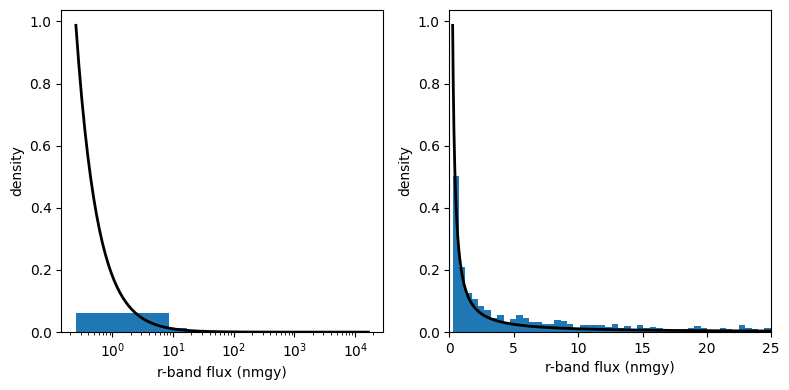

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

_ = ax[0].plot(f, pf, color = 'black', linewidth = 2)
_ = ax[0].hist(fluxes_magcut_oob[fluxes_magcut_oob < trunc], density = True, bins = 2000)
_ = ax[0].set_xscale('log')
_ = ax[0].set_xlabel('r-band flux (nmgy)')
_ = ax[0].set_ylabel('density')

_ = ax[1].plot(f, pf, color = 'black', linewidth = 2)
_ = ax[1].hist(fluxes_magcut_oob[fluxes_magcut_oob < 25], density = True, bins = 50)
_ = ax[1].set_xlim(0, 25)
_ = ax[1].set_xlabel('r-band flux (nmgy)')
_ = ax[1].set_ylabel('density')

_ = fig.tight_layout()

---

### **Flux prior (alternative parametrization)**

We can also define the truncated (i.e., bounded) Pareto distribution above using the parametrization from [this page](https://en.wikipedia.org/wiki/Pareto_distribution#Bounded_Pareto_distribution).

In [19]:
alpha = alpha
L = loc + scale
H = loc + trunc*scale
print(f"alpha = {alpha}, L = {L}, H = {H}")

alpha = 0.22847690351191818, L = 0.2513609826564788, H = 16546.183593750004


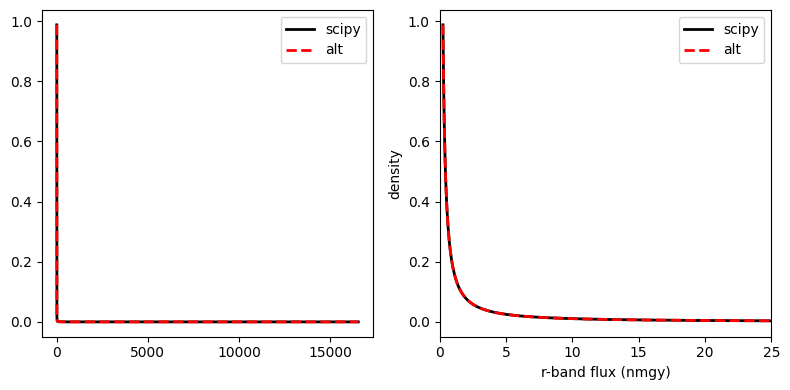

In [20]:
pf_alt = (alpha * (L**alpha) * (f**(-alpha-1))) / (1 - (L/H)**alpha)

fig, ax = plt.subplots(1, 2, figsize = (8, 4))

_ = ax[0].plot(f, pf, color = 'black', linewidth = 2, label = 'scipy')
_ = ax[0].plot(f, pf_alt, color = 'red', linewidth = 2, linestyle = 'dashed', label = 'alt')
_ = ax[0].legend()

_ = ax[1].plot(f, pf, color = 'black', linewidth = 2, label = 'scipy')
_ = ax[1].plot(f, pf_alt, color = 'red', linewidth = 2, linestyle = 'dashed', label = 'alt')
_ = ax[1].set_xlim(0, 25)
_ = ax[1].set_xlabel('r-band flux (nmgy)')
_ = ax[1].set_ylabel('density')
_ = ax[1].legend()

_ = fig.tight_layout()

We can sample from this distribution using inverse transform sampling:

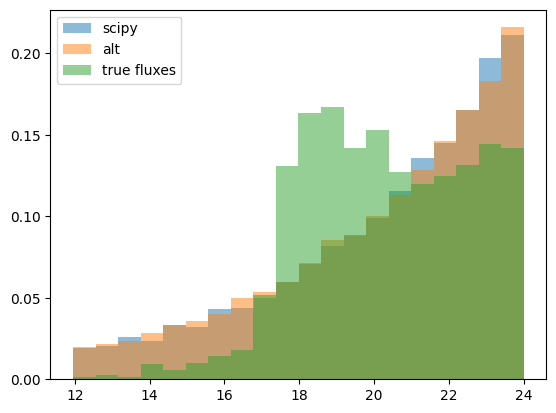

In [21]:
num_samples = 5*fluxes_magcut_oob.shape[0]

unif = torch.rand(num_samples)
samples = ( (H**alpha - unif * (H**alpha) + unif*(L**alpha)) / ((L**alpha) * (H**alpha)) )**(-1/alpha)

_ = plt.hist(convert_nmgy_to_mag(torch.tensor(truncpareto(alpha, trunc, loc, scale).rvs(num_samples))),
             bins = 20, alpha = 0.5, density = True, label = 'scipy')
_ = plt.hist(convert_nmgy_to_mag(samples), bins = 20, alpha = 0.5, density = True, label = 'alt')
_ = plt.hist(convert_nmgy_to_mag(fluxes_magcut), bins = 20, alpha = 0.5, density = True, label = 'true fluxes')
_ = plt.legend()

The `TruncatedPareto` class in `smc/distributions.py` uses this alternative parametrization:

In [22]:
from smc.distributions import TruncatedPareto

my_truncpareto = TruncatedPareto(alpha = alpha, lower = L, upper = H)

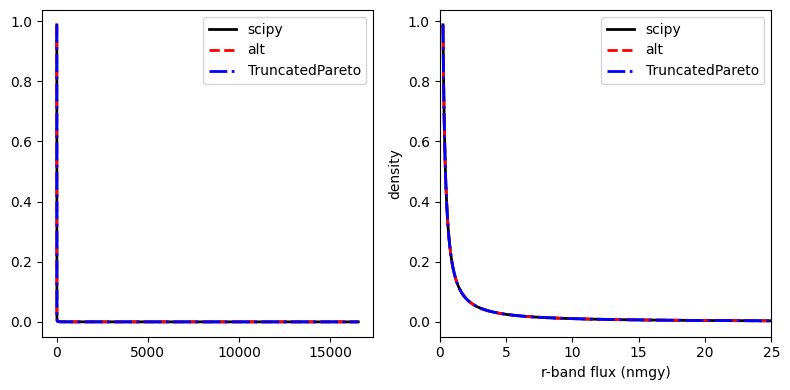

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

_ = ax[0].plot(f, pf, color = 'black', linewidth = 2, label = 'scipy')
_ = ax[0].plot(f, pf_alt, color = 'red', linewidth = 2, linestyle = 'dashed', label = 'alt')
_ = ax[0].plot(f, my_truncpareto.log_prob(torch.tensor(f)).exp(),
               color = 'blue', linewidth = 2, linestyle = 'dashdot', label = 'TruncatedPareto')
_ = ax[0].legend()

_ = ax[1].plot(f, pf, color = 'black', linewidth = 2, label = 'scipy')
_ = ax[1].plot(f, pf_alt, color = 'red', linewidth = 2, linestyle = 'dashed', label = 'alt')
_ = ax[1].plot(f, my_truncpareto.log_prob(torch.tensor(f)).exp(),
               color = 'blue', linewidth = 2, linestyle = 'dashdot', label = 'TruncatedPareto')
_ = ax[1].set_xlim(0, 25)
_ = ax[1].set_xlabel('r-band flux (nmgy)')
_ = ax[1].set_ylabel('density')


_ = ax[1].legend()

_ = fig.tight_layout()

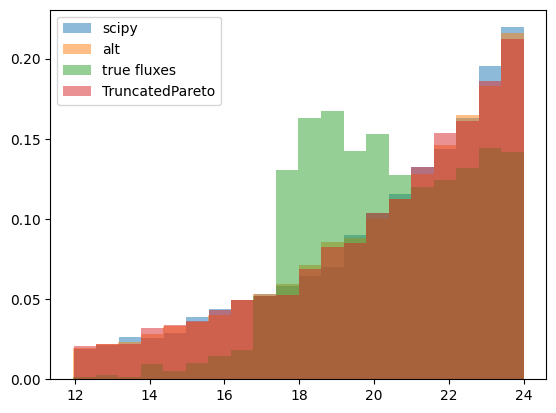

In [24]:
_ = plt.hist(convert_nmgy_to_mag(torch.tensor(truncpareto(alpha, trunc, loc, scale).rvs(num_samples))),
             bins = 20, alpha = 0.5, density = True, label = 'scipy')
_ = plt.hist(convert_nmgy_to_mag(samples), bins = 20, alpha = 0.5, density = True, label = 'alt')
_ = plt.hist(convert_nmgy_to_mag(fluxes_magcut), bins = 20, alpha = 0.5, density = True, label = 'true fluxes')
_ = plt.hist(convert_nmgy_to_mag(my_truncpareto.sample(num_samples)),
             bins = 20, alpha = 0.5, density = True, label = 'TruncatedPareto')
_ = plt.legend()

---

### **Count prior**

We fit a flux prior using the tiles that were not stored above (i.e., the opposite-color squares on the checkerboard).

In [25]:
counts_magcut_oob = tile_counts_magcut[~checkerboard_mask]

In [26]:
# MLE of Poisson rate parameter
rate = (counts_magcut_oob.sum() / ((~checkerboard_mask).sum()))
print(f"rate = {rate.item()}")

rate = 2.4262499809265137


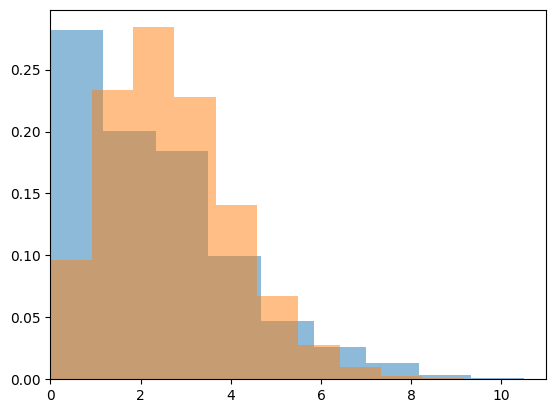

In [27]:
_ = plt.hist(counts_magcut_oob, bins = 12, density = True, alpha = 0.5, label = '')

random_sample = Poisson(rate).sample([100000])
_ = plt.hist(random_sample, bins = random_sample.max().int() + 1, density = True, alpha = 0.5)
_ = plt.xlim(0, 11)

---

### **Image model**

##### Background

We plot the r-band background of the entire SDSS field:

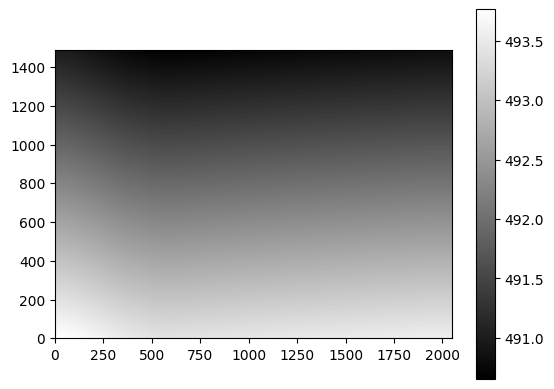

In [28]:
_ = plt.imshow(sdss[0]["background"][2], cmap = 'gray', origin = 'lower')
_ = plt.colorbar()

In [29]:
sdss_background = sdss[0]["background"][2][900:1220, 1728:2048]
print(f'background median = {np.median(sdss_background)}, background std = {sdss_background.std()}')

background median = 491.588623046875, background std = 0.1711219996213913


### Flux calibration

We extract the conversion factor to translate physical units to photon counts for the r-band. This varies slightly across image columns:

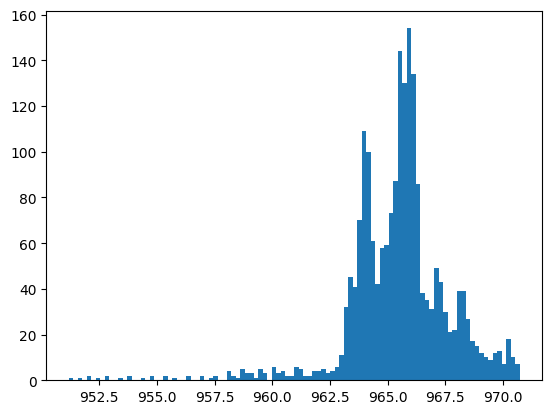

In [30]:
_ = plt.hist(sdss[0]['flux_calibration'][2], bins = 100)

In [31]:
sdss_flux_cal = torch.tensor(sdss[0]['flux_calibration'][2][1728:2048]).unsqueeze(0).expand(320, 320)

In [32]:
print(f'median flux calibration in 320x320 region = {sdss_flux_cal.median()}')

median flux calibration in 320x320 region = 966.0794677734375


We multiply our 320x320 image by the (columnwise) calibration factor and add the background. Then we recreate the tiles and store them:

In [33]:
image_cal_bg = image * sdss_flux_cal + sdss_background
tiles_cal_bg = image_cal_bg.unfold(0, tile_dim, tile_dim).unfold(1, tile_dim, tile_dim)

In [34]:
torch.save(tiles_cal_bg[checkerboard_mask], 'data/tiles.pt')

Now we plot the r-band SDSS point-spread function:

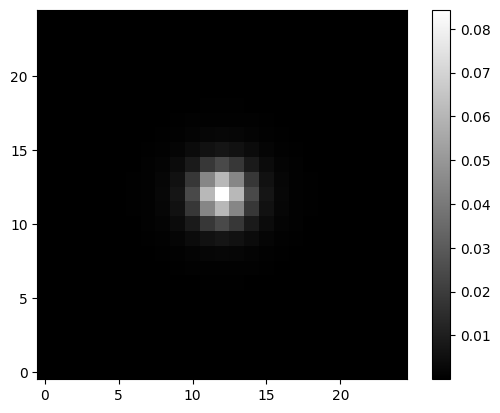

In [35]:
sdss_psf = sdss.psf.psf_galsim[sdss.image_id(0)][2].original.image.array

_ = plt.imshow(sdss_psf, cmap = 'gray', origin = 'lower')
_ = plt.colorbar()

If we fit a Gaussian profile to this PSF, we get the following (isotropic) standard deviation:

In [36]:
h, _ = np.indices(sdss_psf.shape)
sdss_psf_stdev = np.sqrt((((h - 12.0)**2) * sdss_psf).sum())
sdss_psf_stdev

1.9273269405185427

The above PSF is rasterized, so it may not be accurate for sources that don't lie exactly in the middle of a pixel. SDSS actually uses a more complicated PSF that combines a Gaussian core and a power-law wing. The parameters of this model in the r-band are as follows:

In [37]:
sdss.psf.psf_params[sdss.image_id(0)][2]

tensor([1.3600e+00, 4.8475e+00, 8.3333e+00, 3.0000e+00, 1.4400e-01, 6.8779e-03])

We investigate the differences between this model-based PSF, the rasterized SDSS PSF, and a Gaussian PSF in `psf.ipynb`.

---

### **Save fitted prior and image model parameters**

In [38]:
d = {
    "flux_alpha": alpha,
    "flux_lower": L,
    "flux_upper": H,
    "counts_rate": rate.item(),
    "background": np.median(sdss_background),
    "flux_calibration": np.median(sdss_flux_cal),
    "psf_params": sdss.psf.psf_params[sdss.image_id(0)][2]
}

d

{'flux_alpha': 0.22847690351191818,
 'flux_lower': 0.2513609826564788,
 'flux_upper': 16546.183593750004,
 'counts_rate': 2.4262499809265137,
 'background': 491.58862,
 'flux_calibration': 966.0863,
 'psf_params': tensor([1.3600e+00, 4.8475e+00, 8.3333e+00, 3.0000e+00, 1.4400e-01, 6.8779e-03])}

In [39]:
with open('data/params.pkl', 'wb') as f:
    pickle.dump(d, f)

---